# Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import warnings
import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\kevin\Desktop\VSCode\ScaleDux\Startup_Scoring_Dataset.csv')
df.drop('startup_id', axis=1, inplace=True)

In [3]:
df['monthly_burn_rate_inr'] = df['monthly_burn_rate_inr'].max() - df['monthly_burn_rate_inr']

In [4]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
features = [
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'monthly_burn_rate_inr',
    'funds_raised_inr',
    'valuation_inr'
]

In [6]:
model_results = {}

In [7]:
# Create objective function
def define_objective(model_type, random_state):
    def objective(trial):
        weights = np.array([trial.suggest_float(f"w_{f}", 0.0, 1.0) for f in features])
        weights /= weights.sum()  # Normalize to sum 1

        # Create synthetic target
        y = sum(X_scaled[f] * w for f, w in zip(features, weights))
        X_train, X_test, y_train, y_test = train_test_split(X_scaled[features], y, test_size=0.2, random_state=42)

        #  Model initialization based on model type
        if model_type == 'xgboost':
            model = XGBRegressor(
                n_estimators=100,
                max_depth=trial.suggest_int("max_depth", 3, 10),
                learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
                subsample=trial.suggest_float("subsample", 0.6, 1.0),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
                random_state=random_state,
                verbosity=0
            )
        elif model_type == 'randomforest':
            model = RandomForestRegressor(
                n_estimators=100,
                max_depth=trial.suggest_int("max_depth", 3, 10),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
                random_state=random_state
            )
        elif model_type == 'gboost':
            model = GradientBoostingRegressor(
                n_estimators=100,
                max_depth=trial.suggest_int("max_depth", 3, 10),
                learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
                subsample=trial.suggest_float("subsample", 0.6, 1.0),
                random_state=random_state
            )
        else:
            raise ValueError("Invalid model type.")

        # Train and evaluate the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return r2_score(y_test, y_pred)
    return objective

In [8]:
# Perform optimization for each model type
models = ['xgboost', 'randomforest', 'gboost']
SEED = 2147483647

for model_name in models:
    print(f"\n Optimizing {model_name.upper()}...")
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction='maximize', sampler=sampler)

    study.optimize(
        define_objective(model_name, random_state=SEED), 
        n_trials=50, 
        show_progress_bar=True)

    model_results[model_name] = study

[I 2025-07-22 22:59:50,219] A new study created in memory with name: no-name-56fd1080-b487-42f4-9d43-7f088bf4d1f8



 Optimizing XGBOOST...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-22 22:59:50,354] Trial 0 finished with value: 0.8527427312388253 and parameters: {'w_team_experience': 0.3933911315501387, 'w_market_size_million_usd': 0.6566618430544519, 'w_monthly_active_users': 0.08629079684294616, 'w_monthly_burn_rate_inr': 0.9643837803447597, 'w_funds_raised_inr': 0.6211251115394647, 'w_valuation_inr': 0.7450811007700753, 'max_depth': 3, 'learning_rate': 0.29590429353187536, 'subsample': 0.7792271649114344, 'colsample_bytree': 0.660874932392486}. Best is trial 0 with value: 0.8527427312388253.
[I 2025-07-22 22:59:50,394] Trial 1 finished with value: 0.8434019560279771 and parameters: {'w_team_experience': 0.5301071542796959, 'w_market_size_million_usd': 0.12817063817946295, 'w_monthly_active_users': 0.796846860069254, 'w_monthly_burn_rate_inr': 0.44221483158201225, 'w_funds_raised_inr': 0.003351949543064725, 'w_valuation_inr': 0.44374932503450293, 'max_depth': 5, 'learning_rate': 0.20520356362565825, 'subsample': 0.6154982318374892, 'colsample_bytree':

[I 2025-07-22 22:59:54,088] A new study created in memory with name: no-name-edeace1a-97b9-4411-b192-e8961a7ee9a7


[I 2025-07-22 22:59:53,945] Trial 47 finished with value: 0.5974089396484581 and parameters: {'w_team_experience': 0.16069917357359254, 'w_market_size_million_usd': 0.04213266074127644, 'w_monthly_active_users': 0.7685145795379583, 'w_monthly_burn_rate_inr': 0.10978191385798661, 'w_funds_raised_inr': 0.6698759026526019, 'w_valuation_inr': 0.4681510043332164, 'max_depth': 4, 'learning_rate': 0.011968657304671032, 'subsample': 0.8663936196732058, 'colsample_bytree': 0.733117680422336}. Best is trial 41 with value: 0.9474477743309435.
[I 2025-07-22 22:59:54,017] Trial 48 finished with value: 0.794383930661233 and parameters: {'w_team_experience': 0.6068356830400359, 'w_market_size_million_usd': 0.6236868231987365, 'w_monthly_active_users': 0.8515216450351641, 'w_monthly_burn_rate_inr': 0.17731767684114774, 'w_funds_raised_inr': 0.6132570123858955, 'w_valuation_inr': 0.16389015886671074, 'max_depth': 5, 'learning_rate': 0.28169307041679575, 'subsample': 0.7909297172029375, 'colsample_bytre

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-22 22:59:54,301] Trial 0 finished with value: 0.6120414733889659 and parameters: {'w_team_experience': 0.3933911315501387, 'w_market_size_million_usd': 0.6566618430544519, 'w_monthly_active_users': 0.08629079684294616, 'w_monthly_burn_rate_inr': 0.9643837803447597, 'w_funds_raised_inr': 0.6211251115394647, 'w_valuation_inr': 0.7450811007700753, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6120414733889659.
[I 2025-07-22 22:59:54,384] Trial 1 finished with value: 0.7913939756854914 and parameters: {'w_team_experience': 0.15218733098121495, 'w_market_size_million_usd': 0.5301071542796959, 'w_monthly_active_users': 0.12817063817946295, 'w_monthly_burn_rate_inr': 0.796846860069254, 'w_funds_raised_inr': 0.44221483158201225, 'w_valuation_inr': 0.003351949543064725, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7913939756854914.
[I 2025-07-22 22:59:54,467] Trial 2 finished with value:

[I 2025-07-22 22:59:59,810] A new study created in memory with name: no-name-9058d8fd-a928-48b1-9030-598c514d4db1


[I 2025-07-22 22:59:59,808] Trial 49 finished with value: 0.8916911968765286 and parameters: {'w_team_experience': 0.2331321918390239, 'w_market_size_million_usd': 0.43235359126015477, 'w_monthly_active_users': 0.6492746964174008, 'w_monthly_burn_rate_inr': 0.31763387599428355, 'w_funds_raised_inr': 0.6494481393301041, 'w_valuation_inr': 0.09216010552921626, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.9355713090375128.

 Optimizing GBOOST...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-22 22:59:59,872] Trial 0 finished with value: 0.8857129208710671 and parameters: {'w_team_experience': 0.3933911315501387, 'w_market_size_million_usd': 0.6566618430544519, 'w_monthly_active_users': 0.08629079684294616, 'w_monthly_burn_rate_inr': 0.9643837803447597, 'w_funds_raised_inr': 0.6211251115394647, 'w_valuation_inr': 0.7450811007700753, 'max_depth': 3, 'learning_rate': 0.29590429353187536, 'subsample': 0.7792271649114344}. Best is trial 0 with value: 0.8857129208710671.
[I 2025-07-22 22:59:59,930] Trial 1 finished with value: 0.9076953151951752 and parameters: {'w_team_experience': 0.15218733098121495, 'w_market_size_million_usd': 0.5301071542796959, 'w_monthly_active_users': 0.12817063817946295, 'w_monthly_burn_rate_inr': 0.796846860069254, 'w_funds_raised_inr': 0.44221483158201225, 'w_valuation_inr': 0.003351949543064725, 'max_depth': 6, 'learning_rate': 0.09991465453495708, 'subsample': 0.8692462946560804}. Best is trial 1 with value: 0.9076953151951752.
[I 2025-0

# Model development with optimal hyperparameters

In [9]:
model_classes = {
    'randomforest': (RandomForestRegressor, 'salmon'),
    'gboost': (GradientBoostingRegressor, 'lightgreen'),
    'xgboost': (XGBRegressor, 'skyblue')
}


--------------------------------------------------
RANDOMFOREST Feature Importances
--------------------------------------------------


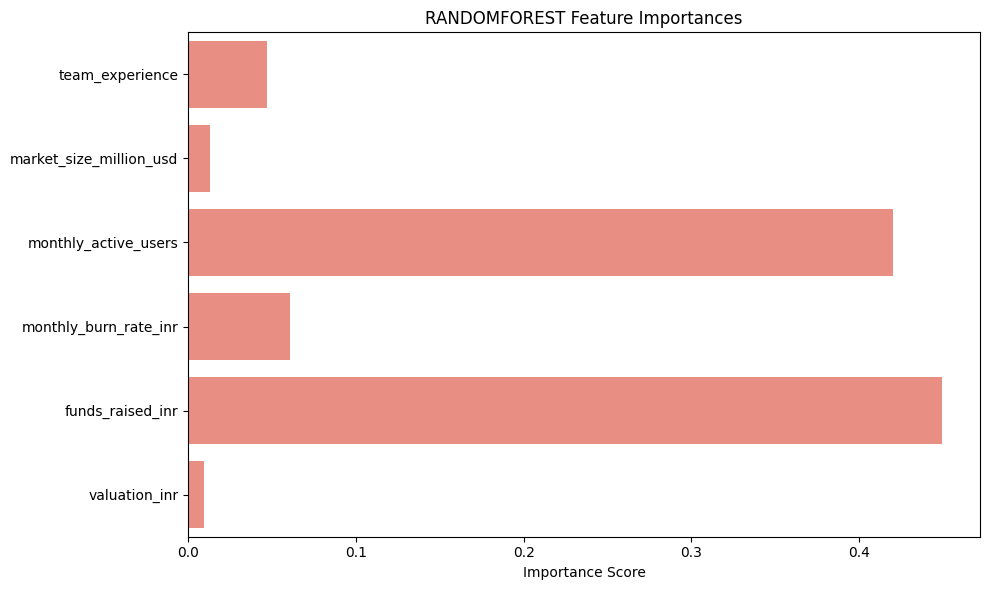


--------------------------------------------------
GBOOST Feature Importances
--------------------------------------------------


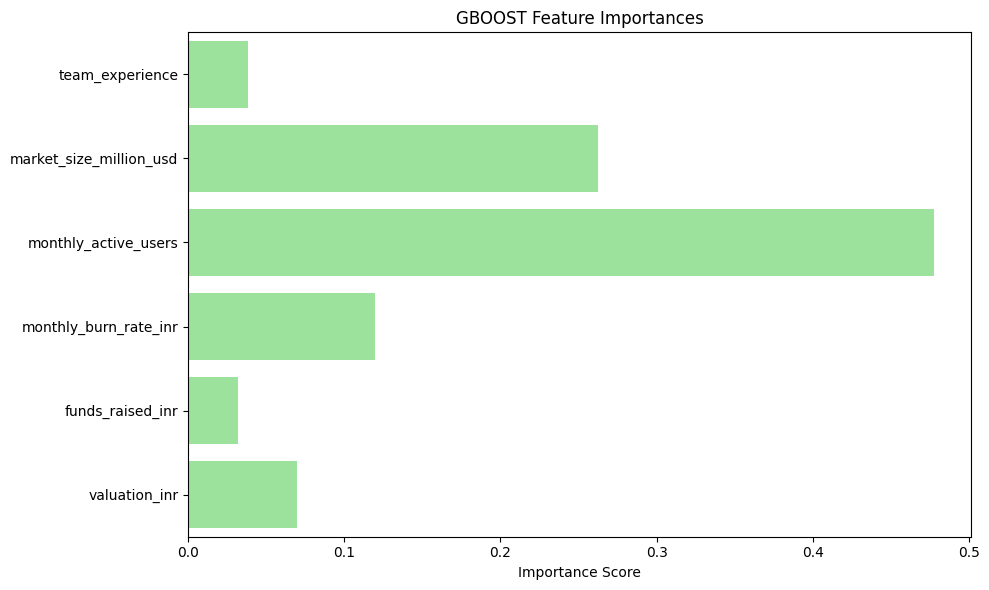


--------------------------------------------------
XGBOOST Feature Importances
--------------------------------------------------


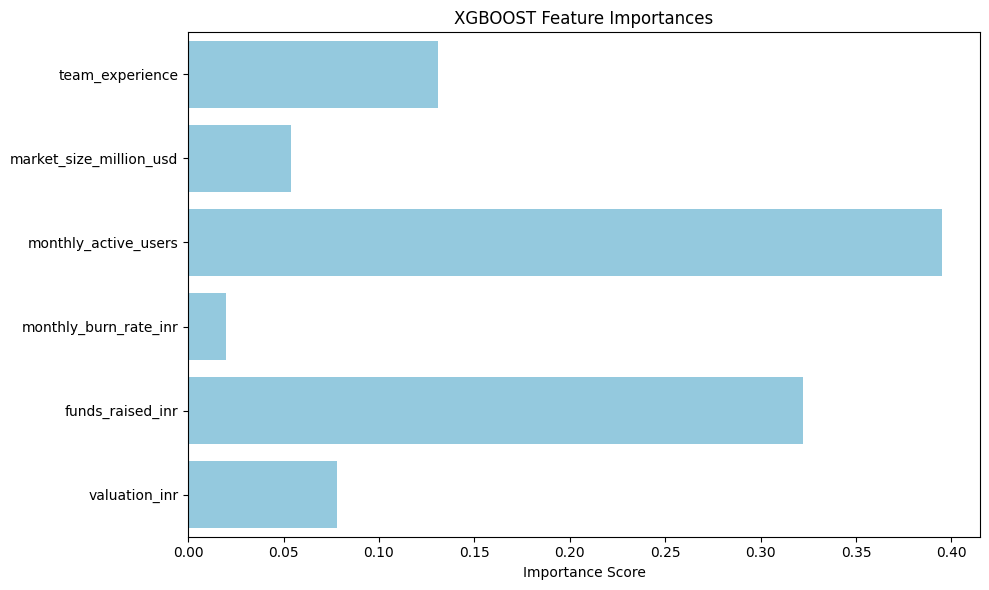

In [10]:
DASH = '-' * 50
for name, (Model, color) in model_classes.items():
    print(f"\n{DASH}\n{name.upper()} Feature Importances\n{DASH}")
    # Get best weights and normalize
    weights = np.array([model_results[name].best_params[f"w_{f}"] for f in features])
    weights /= weights.sum()

    # Generate synthetic target
    y = sum(X_scaled[f] * w for f, w in zip(features, weights))
    X_train, X_test, y_train, y_test = train_test_split(X_scaled[features], y, test_size=0.2, random_state=42)

    # Extract model-specific hyperparameters
    params = model_results[name].best_params
    if name == 'randomforest':
        model = Model(
            n_estimators=100,
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=SEED
        )
    elif name == 'gboost':
        model = Model(
            n_estimators=100,
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            random_state=SEED
        )
    elif name == 'xgboost':
        model = Model(
            n_estimators=100,
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            random_state=SEED
        )

    # Train model
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features, orient='h', color=color)
    plt.title(f"{name.upper()} Feature Importances")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

In [11]:
# Print final R² scores
print("Final R² Scores:")
for model_name, study in model_results.items():
    print(f"{model_name.upper():10s}: {study.best_value:.4f}")

Final R² Scores:
XGBOOST   : 0.9474
RANDOMFOREST: 0.9356
GBOOST    : 0.9565


In [12]:
# Extract best weights for each model
def extract_weights(model_key):
    weights = np.array([model_results[model_key].best_params[f"w_{f}"] for f in features]) 
    weights /= weights.sum() # Normalize to sum to 1
    return weights

In [13]:
weights_dict = {
    'Feature': features,
    'XGBoost': extract_weights('xgboost'),
    'RandomForest': extract_weights('randomforest'),
    'GradientBoost': extract_weights('gboost'),
}

In [14]:
weights_df = pd.DataFrame(weights_dict)
weights_df['Average'] = weights_df[['XGBoost', 'RandomForest', 'GradientBoost']].mean(axis=1)
weights_df = weights_df.sort_values(by='Average', ascending=False)
print("\nAverage Weights Across Models:")
print(weights_df)


Average Weights Across Models:
                   Feature   XGBoost  RandomForest  GradientBoost   Average
2     monthly_active_users  0.322616      0.323663       0.313828  0.320036
4         funds_raised_inr  0.336773      0.278042       0.047403  0.220739
1  market_size_million_usd  0.019227      0.101082       0.329991  0.150100
5            valuation_inr  0.185132      0.002592       0.146988  0.111571
3    monthly_burn_rate_inr  0.026171      0.154462       0.134317  0.104983
0          team_experience  0.110082      0.140159       0.027473  0.092571


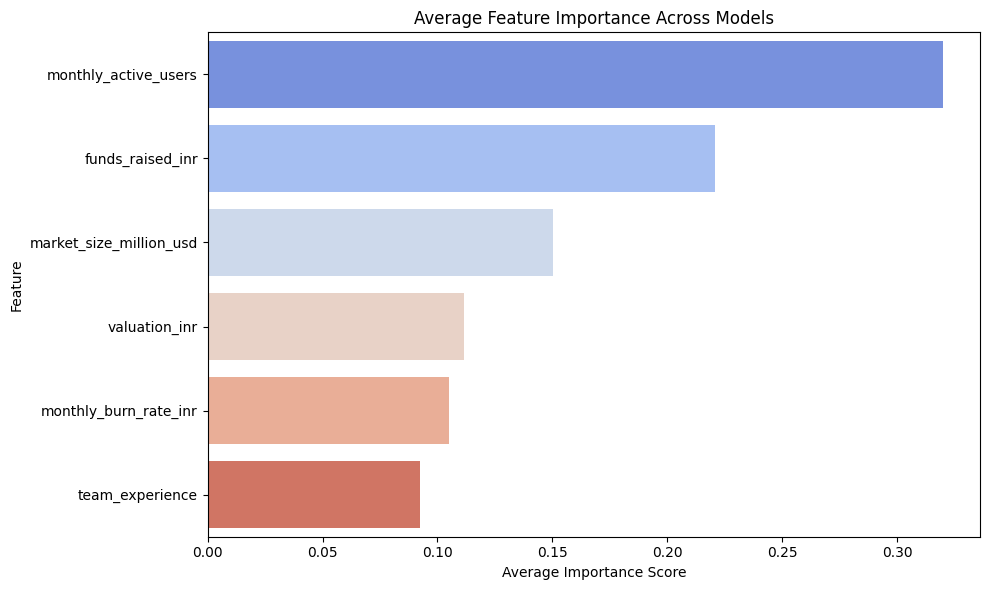

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=weights_df, y="Feature", x="Average", palette="coolwarm")
plt.title("Average Feature Importance Across Models")
plt.xlabel("Average Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(r'C:\Users\kevin\Desktop\VSCode\ScaleDux\output\feature_importances_optimized.png')
plt.show()